# Study of Energy Consumption Patterns in the US
In this project, we utilize a dataset of Hourly Energy Consumption from American Electric Power, one of the biggest US electricity providers, provided by PJM Interconnection LLC in Kaggle.

We aim to extract insights on how electricity consumption is distributed accross time and how it has evolved over the past few years.

# Load libraries and data

In [ ]:
import os
from google.colab import drive

import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

In [ ]:
drive.mount("/content/drive")
data_dir = "/content/drive/My Drive/Codigo/energy consumption"

Mounted at /content/drive


# Dataset info and preprocessing

In [ ]:
df = pd.read_csv(f"{data_dir}/AEP_hourly.csv")

# Display head and tail of the dataset, along with dimensions
df

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0
...,...,...
121268,2018-01-01 20:00:00,21089.0
121269,2018-01-01 21:00:00,20999.0
121270,2018-01-01 22:00:00,20820.0
121271,2018-01-01 23:00:00,20415.0


In [ ]:
# Display some statistical values of the dataset
df.describe()

,AEP_MW
count,121273.000000
mean,15499.513717
std,2591.399065
min,9581.000000
25%,13630.000000
50%,15310.000000
75%,17200.000000
max,25695.000000


In [ ]:
# Are there any missing or incorrect values?
print(f'NULL values: \n{df.isnull().sum()}\n')
print(f'INF values: \n{np.isinf(df["AEP_MW"]).any()}\n')

NULL values: 
Datetime    0
AEP_MW      0
dtype: int64

INF values: 
False



In [ ]:
# Check the order and the years covered
df.sort_values("Datetime", inplace=True)

print(df.iat[-1,0])
print(df.iat[0,0])

2018-08-03 00:00:00
2004-10-01 01:00:00


In [ ]:
print("The dataset covers approximately 13 years")
print("We can also see that 2004 and 2018 are incomplete.")

The dataset covers approximately 13 years
We can also see that 2004 and 2018 are incomplete.


In [ ]:
# Check if other years are incomplete

# Convert 'Datetime' to datetime objects
df["Datetime"] = pd.to_datetime(df["Datetime"])

df["Year"] = df["Datetime"].dt.year

hours_per_year = df["Year"].value_counts()

def hours_in_year(year):
  if year % 4 == 0 and (year % 100 != 0 or year % 400 == 0):
    return 366 * 24  # Leap year
  else:
    return 365 * 24 # Regular year

missing_hours_per_year = hours_per_year
for i in hours_per_year.index:
  missing_hours_per_year.loc[i] = hours_in_year(i) - hours_per_year.loc[i]

missing_hours_per_year

,count
Year,
2016,0
2008,2
2012,3
2015,0
2017,0
2014,1
2005,2
2006,2
2007,2


In [ ]:
# As they miss only 3 hours maximum, ignore them and delete 2004 and 2018
# If needed, we could fill the missing values with an average
rows_to_drop = df[df["Year"].isin([2004, 2018])].index
df.drop(rows_to_drop, axis=0, inplace=True)
df.sort_values("Datetime", inplace=True, ignore_index=True)
df

,Datetime,AEP_MW,Year
0,2005-01-01 00:00:00,12892.0,2005
1,2005-01-01 01:00:00,12316.0,2005
2,2005-01-01 02:00:00,11890.0,2005
3,2005-01-01 03:00:00,11579.0,2005
4,2005-01-01 04:00:00,11461.0,2005
...,...,...,...
113926,2017-12-31 19:00:00,19608.0,2017
113927,2017-12-31 20:00:00,19442.0,2017
113928,2017-12-31 21:00:00,19323.0,2017
113929,2017-12-31 22:00:00,19092.0,2017


# Data analysis

## Consumption evolution accross the years

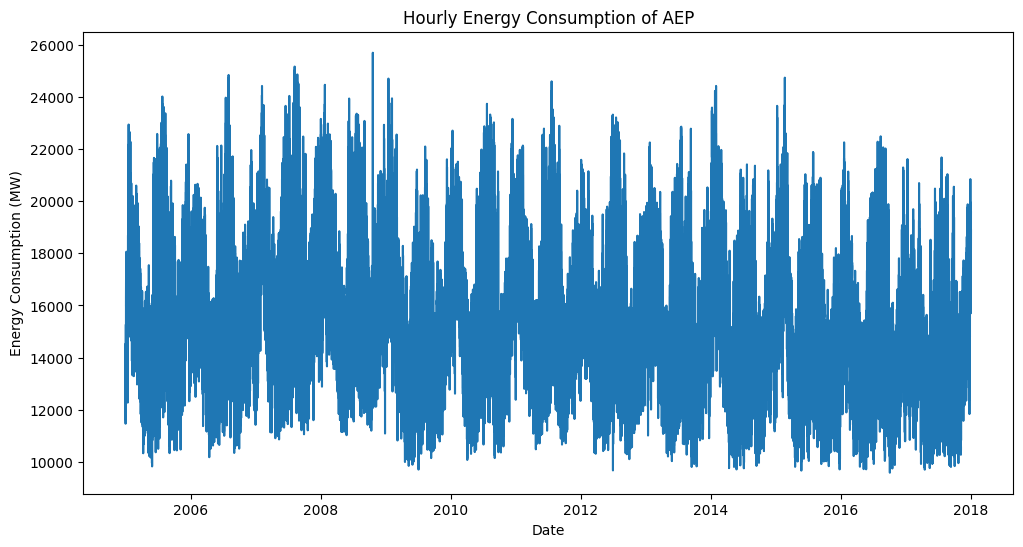

In [ ]:
# Plot all the data

plt.figure(figsize=(12, 6))
sns.lineplot(x=df["Datetime"], y=df["AEP_MW"])
plt.title("Hourly Energy Consumption of American Electric Power")
plt.xlabel("Date")
plt.ylabel("Energy Consumption (MW)")
plt.show()

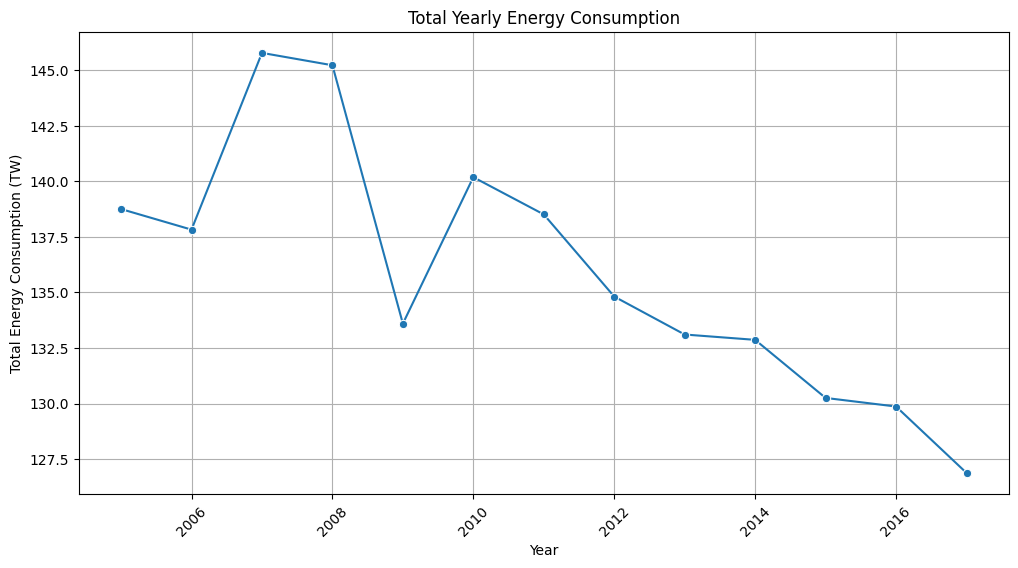

In [ ]:
# Plot the total yearly energy consumption

# Group by year and calculate the total AEP_MW for each year
yearly_total_aep = df.groupby('Year')['AEP_MW'].sum().apply(lambda x: x/1000000)

# Create a plot using Seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(x=yearly_total_aep.index, y=yearly_total_aep.values, marker='o')
plt.title('Total Yearly Energy Consumption')
plt.xlabel('Year')
plt.ylabel('Total Energy Consumption (TW)')
plt.grid(visible=True)
plt.xticks(rotation=45)
plt.show()

- Conclussions: There seems to be a fairly consistent decline accross the years, which could be attributed to a drop in the clients of the company. Because of this, it is more interesting to look for differences between months and days if we want to infer consumption patterns.

## Monthly consumption patterns

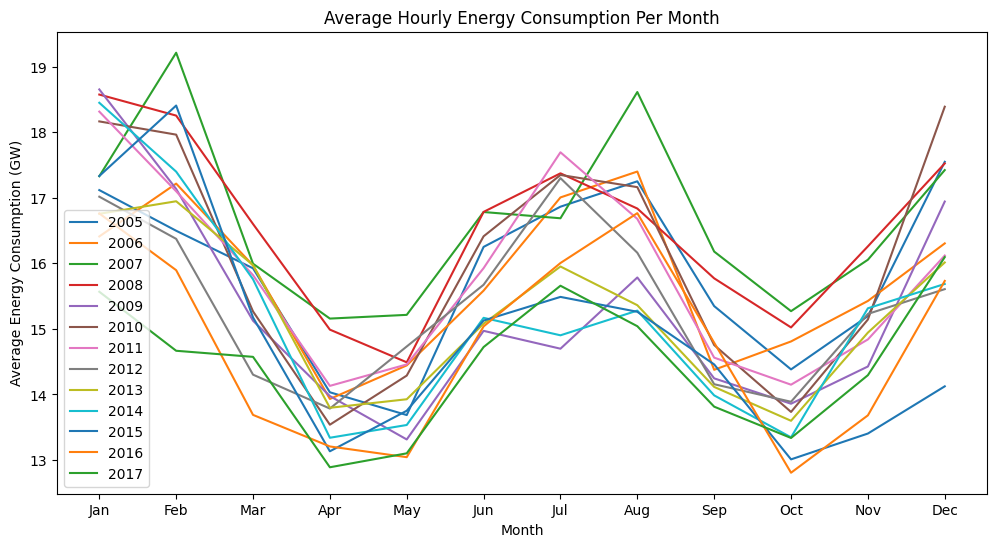

In [ ]:
# Plot the energy consumption by month

df["Month"] = df["Datetime"].dt.month

# Create a plot using Seaborn
plt.figure(figsize=(12, 6))

# Group by year and month and divide by 1000
monthly_df = df.groupby(["Year", "Month"])["AEP_MW"].mean().apply(lambda x: x / 1000)

# Add a line in the plot for each year in the dataset
for year in monthly_df.index.levels[0]:
  filtered_df = monthly_df.loc[year]
  sns.lineplot(x=filtered_df.index, y=filtered_df, label=year)

plt.title('Average Hourly Energy Consumption Per Month')
plt.xlabel('Month')
plt.ylabel('Average Energy Consumption (GW)')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul',
                          'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.xticks(range(1, 13))
plt.legend()
plt.show()

- Conclussions: We can see that there is a consistent increase in energy consumption in the months of summer and winter, probably related to the use of HVAC systems.

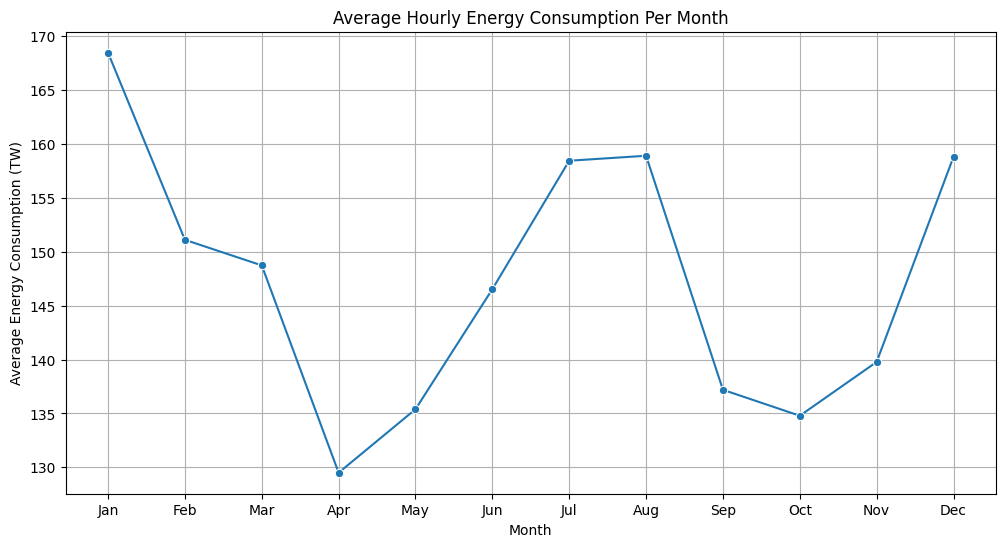

In [ ]:
# Plot the average monthly energy consumption accross the years

# Group by month and calculate the average AEP_MW for each month
monthly_avg_aep = df.groupby('Month')['AEP_MW'].sum().apply(lambda x: x/1000000)

# Create a plot using Seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(monthly_avg_aep, marker='o')
plt.title('Average Hourly Energy Consumption Per Month')
plt.xlabel('Month')
plt.ylabel('Average Energy Consumption (TW)')
plt.grid(visible=True)

# Set x-axis ticks and labels for each month
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul',
                          'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

plt.show()

In [ ]:
# Display the monthly energy consumption increases with respect to the month with the lowest consumption

# Calculate the average energy consumption per month
monthly_avg_aep = df.groupby('Month')['AEP_MW'].mean().apply(lambda x: x/1000)

# Find the minimum average consumption
min_avg_consumption = monthly_avg_aep.min()

# Create a new DataFrame to store the results
result_df = pd.DataFrame({'Month': ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                                    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
                         'Average Hourly Consumption': monthly_avg_aep.values})

# Calculate the percentage increase with respect to the minimum average consumption
result_df['Percentage Increase'] = "+" + (((result_df['Average Hourly Consumption']
                                            - min_avg_consumption) / min_avg_consumption)
                                            * 100).round(2).astype(str) + '%'


# Round the average consumption to 2 decimal places
result_df['Average Hourly Consumption'] = result_df['Average Hourly Consumption'].round(2)

# Display the table
print("Average consumption per month between 2005 and 2017")
print(result_df)

Average consumption per month between 2005 and 2017
   Month  Average Hourly Consumption Percentage Increase
0    Jan                       17.42             +25.88%
1    Feb                       17.16             +23.98%
2    Mar                       15.40             +11.27%
3    Apr                       13.84               +0.0%
4    May                       14.00              +1.15%
5    Jun                       15.66             +13.13%
6    Jul                       16.38             +18.39%
7    Aug                       16.43             +18.73%
8    Sep                       14.66              +5.92%
9    Oct                       13.94              +0.72%
10   Nov                       14.94              +7.95%
11   Dec                       16.42             +18.68%


Conclussions: The months with the highest average consumption are January and February, while the ones with the lowest are April and October. The consumption difference between them amounts to 25%.

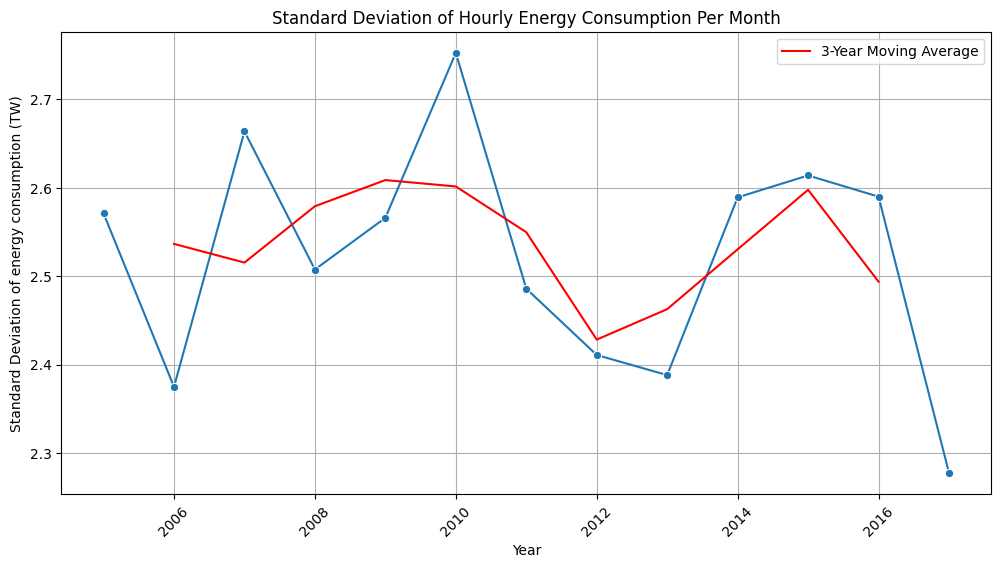

In [ ]:
# Check if the monthly differences have increased by plotting the monthly standard deviation

# Group by year and calculate the standard deviation of Energy Consumption for each year
yearly_std_aep = df.groupby('Year')['AEP_MW'].std().apply(lambda x: x/1000)

# Create a plot using Seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(x=yearly_std_aep.index, y=yearly_std_aep.values, marker='o')

# Add the 3-year moving average
yearly_std_aep_rolling = yearly_std_aep.rolling(window=3, center=True).mean()
sns.lineplot(x=yearly_std_aep_rolling.index, y=yearly_std_aep_rolling.values,
             label='3-Year Moving Average', color='red')

plt.title('Standard Deviation of Hourly Energy Consumption Per Month')
plt.xlabel('Year')
plt.ylabel('Standard Deviation of energy consumption (TW)')
plt.xticks(rotation=45)
plt.grid(visible=True)
plt.show()

- Conclussions: It does not seem clear that the energy consumption variation by month has neither increased nor decreased during the studied timeframe.


## Daily consumption patterns

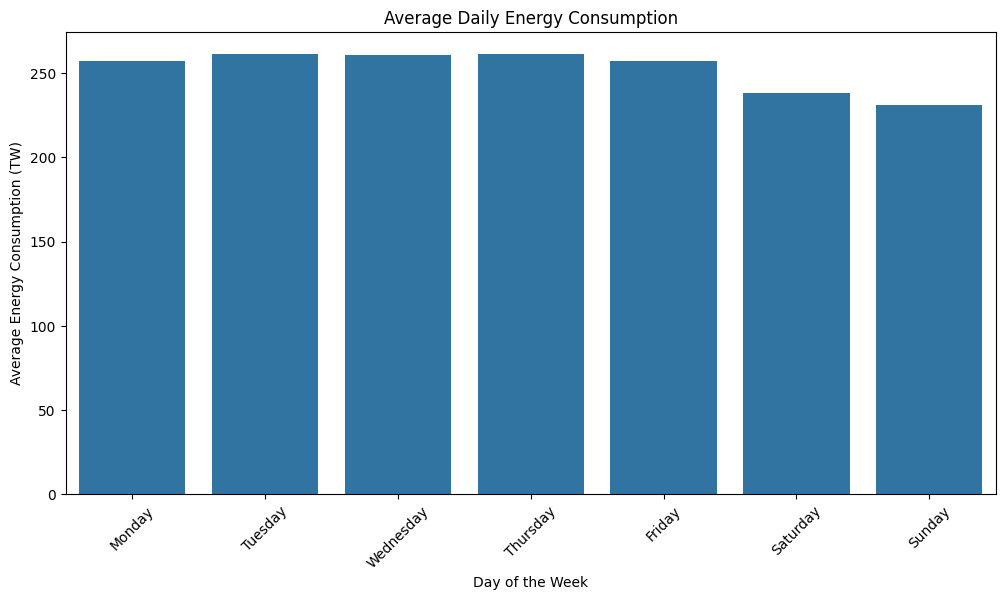

In [ ]:
# Plot the energy consumption by day of the week

df["Weekday"] = df["Datetime"].dt.day_name()

# Group by day of the week and calculate the average AEP_MW for each day
average_aep_by_day = df.groupby('Weekday')['AEP_MW'].sum().apply(lambda x: x/1000000)

# Define the desired order of days
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Reindex the average_aep_by_day Series to match the desired order
average_aep_by_day = average_aep_by_day.reindex(day_order)

# Create a plot using Seaborn
plt.figure(figsize=(12, 6))
sns.barplot(x=average_aep_by_day.index, y=average_aep_by_day.values)

plt.title('Average Daily Energy Consumption')
plt.xlabel('Day of the Week')
plt.ylabel('Average Energy Consumption (TW)')

# Set x-axis ticks and labels to day names
plt.xticks(rotation=45)

plt.show()

In [ ]:
# Display the daily energy consumption increases with respect to the day with the lowest consumption

# Calculate the average energy consumption per day
daily_avg_aep = df.groupby('Weekday')['AEP_MW'].sum().apply(lambda x: x/1000000)

day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_avg_aep = average_aep_by_day.reindex(day_order)

# Find the minimum average consumption
min_avg_consumption = daily_avg_aep.min()

# Create a new DataFrame to store the results
result_df = pd.DataFrame({'Day': ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat',
                                    'Sun'],
                         'Average Consumption': daily_avg_aep.values})

# Calculate the percentage increase with respect to the minimum average consumption
result_df['Percentage Increase'] = "+" + (((result_df['Average Consumption']
                                            - min_avg_consumption) / min_avg_consumption)
                                            * 100).round(2).astype(str) + '%'

# Round the average consumption to 2 decimal places
result_df['Average Consumption'] = result_df['Average Consumption'].round(2)

# Display the table
print("Average consumption per day (TW) between 2005 and 2017")
print(result_df)

Average consumption per day (TW) between 2005 and 2017
   Day  Average Consumption Percentage Increase
0  Mon               257.33             +11.25%
1  Tue               261.51             +13.06%
2  Wed               260.93             +12.81%
3  Thu               261.25             +12.95%
4  Fri               257.10             +11.15%
5  Sat               238.22              +2.99%
6  Sun               231.31               +0.0%


- Conclussions: The weekends have an inferior energy consumption, Sunday being the day with the lowest consumption among them.

## Hourly consumption patterns

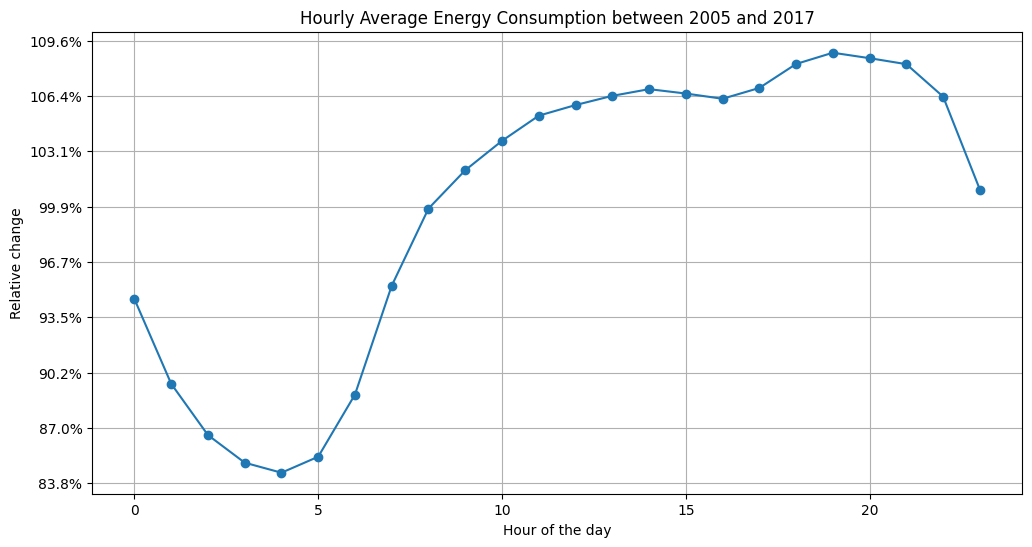

In [ ]:
# Display the relative average energy consumption per hour

df['Hour'] = df['Datetime'].dt.hour

# Calculate the average consumption for every hour
avg_hour_series = df.groupby('Hour')['AEP_MW'].mean()

fig, ax = plt.subplots(figsize=(12,6))
ax.plot(avg_hour_series, marker='o')

ax.set_title("Hourly Average Energy Consumption between 2005 and 2017")
ax.set_xlabel("Hour of the day")
ax.set_ylabel("Relative change")
ax.grid(visible=True)

# Put percentages in the y axis
avg_hourly_consumption = np.mean(avg_hour_series)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=avg_hourly_consumption))

- Conclussions: energy consumption increases at evening by an amount closer to 10% in respect to the average. After midnight, energy consumption decreases to -15%. There is still considerable energy consumption during the night, where it could be interesting to look for the source.

In [ ]:
# Plot the relative hourly energy consumption for every year

# Calculate the average hourly energy consumption
year_avg_hour_series = df.groupby(["Year", "Hour"])["AEP_MW"].mean()
avg_consumption = year_avg_hour_series.groupby("Year").mean()

# Create a dictionary with the consumption increase with respect to that average
percentages_dict = {}

def get_percentage(num):
  """1.054176 -> 5.4 for a given number"""
  percentage = round((num - 1) * 100, 1)
  return percentage

# Fill dictionary with the values.
for i in year_avg_hour_series.index.levels[0]:

  # The keys are the years. The values are a list of the energy increases for each hour.
  percentages_list = [
      get_percentage(x/avg_consumption.at[i])
      for x in year_avg_hour_series.at[i]
      ]
  percentages_dict[f'{i}'] = percentages_list

# Create a DataFrame from the dictionary
year_hour_changes_df = pd.DataFrame(percentages_dict)

year_hour_changes_df

,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,-5.0,-5.3,-5.3,-5.1,-5.3,-5.3,-5.1,-5.4,-5.6,-5.5,-5.9,-6.4,-6.2
1,-10.6,-10.7,-10.6,-10.1,-10.4,-10.3,-10.0,-10.3,-10.3,-10.1,-10.6,-11.0,-10.6
2,-13.9,-13.8,-13.8,-12.9,-13.3,-13.4,-13.0,-13.4,-13.1,-12.8,-13.4,-13.9,-13.4
3,-15.7,-15.4,-15.6,-14.5,-15.0,-15.1,-14.7,-15.1,-14.6,-14.2,-14.9,-15.3,-15.0
4,-16.5,-16.1,-16.3,-15.0,-15.5,-15.7,-15.3,-15.8,-15.1,-14.6,-15.3,-15.9,-15.5
5,-15.8,-15.2,-15.5,-14.1,-14.6,-14.9,-14.5,-14.9,-14.1,-13.5,-14.3,-14.8,-14.4
6,-12.2,-11.2,-11.9,-10.5,-10.8,-11.4,-11.0,-11.5,-10.4,-9.9,-10.6,-11.2,-10.8
7,-5.7,-4.2,-5.5,-4.2,-4.1,-5.2,-4.8,-5.4,-4.0,-3.6,-4.4,-5.1,-4.7
8,-0.8,0.6,-0.8,0.2,0.7,-0.8,-0.4,-0.9,0.4,0.6,-0.1,-0.9,-0.5
9,1.9,2.8,1.4,2.4,3.0,1.6,1.8,1.4,2.5,2.6,2.0,1.3,1.6


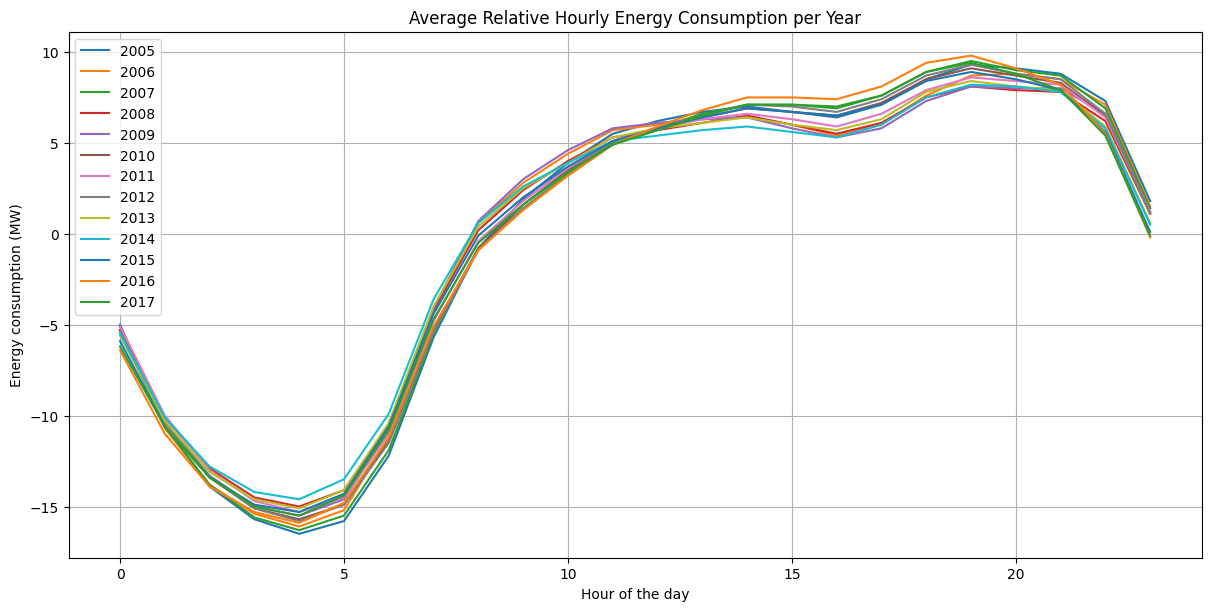

In [ ]:
# Plot the dataframe
fig, ax = plt.subplots(figsize=(12,6), layout='constrained')
for i in year_hour_changes_df.columns:
  ax.plot(year_hour_changes_df[f'{i}'])

ax.set_title("Average Relative Hourly Energy Consumption per Year", fontsize=12)
ax.set_xlabel("Hour of the day")
ax.set_ylabel("Energy consumption (MW)")
ax.legend(year_hour_changes_df.columns)
ax.grid(visible=True)
ax.grid(visible=True)
plt.show()

- Conclussions: It is hard to see any trend, because the lines are too close to each other. We could try another approach.

[]

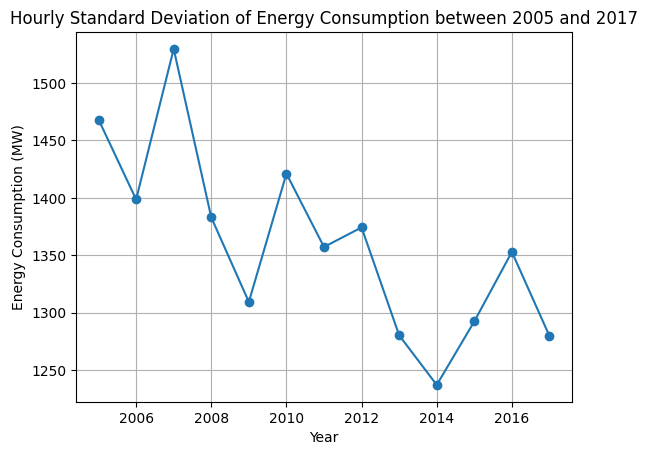

In [ ]:
# Check how the difference between hours has evolved accross the years using
# the standard deviation

# Calculate the standard deviation for every year
year_std_hour_series = year_avg_hour_series.groupby("Year").std()

fig, ax = plt.subplots()

ax.plot(year_std_hour_series, marker='o')

ax.set_title("Hourly Standard Deviation of Energy Consumption between 2005 and 2017")
ax.set_xlabel("Year")
ax.set_ylabel("Energy Consumption (MW)")
plt.grid(visible=True)

plt.plot()

- Conclussions: In this plot, it seems that the difference in consumption between the different hours of the day has dropped. This could be due to a relative increase in energy consumption after midnight. It could be interesting to research the causes.

## Peaks of energy consumption

In [ ]:
# Get the hourly peaks of energy consumption per year

hour_peaks_idx = df.groupby("Year")["AEP_MW"].idxmax()
hour_peaks_df = df.loc[hour_peaks_idx, :]
hour_peaks_df["Increase above average"] = round((hour_peaks_df['AEP_MW'] / np.mean(df['AEP_MW']) - 1) * 100, 2)
hour_peaks_df

,Datetime,AEP_MW,Year,Month,Weekday,Hour,Increase above average
4959,2005-07-26 16:00:00,24015.0,2005,7,Tuesday,16,54.78
13887,2006-08-02 18:00:00,24842.0,2006,8,Wednesday,18,60.11
22786,2007-08-08 15:00:00,25164.0,2007,8,Wednesday,15,62.19
33319,2008-10-20 14:00:00,25695.0,2008,10,Monday,14,65.61
35424,2009-01-16 08:00:00,24703.0,2009,1,Friday,8,59.22
48700,2010-07-23 15:00:00,23736.0,2010,7,Friday,15,52.99
57411,2011-07-21 17:00:00,24597.0,2011,7,Thursday,17,58.54
65663,2012-06-29 15:00:00,23320.0,2012,6,Friday,15,50.30
74876,2013-07-18 15:00:00,22858.0,2013,7,Thursday,15,47.33
79572,2014-01-30 08:00:00,24421.0,2014,1,Thursday,8,57.40


In [ ]:
print(f"The highest energy consumption that AEP has provided was "
      f"{np.max(hour_peaks_df['AEP_MW'])} MW, "
      f"{hour_peaks_df.loc[hour_peaks_df['AEP_MW'].idxmax(), 'Increase above average']}% above the average.")

The highest energy consumption that AEP has provided was 25695.0 MW, 65.61% above the average.


In [ ]:
# Plot the average energy consumption for a month along with the maximum and minimum

import calendar

def plot_month(year, month):
  """Plots the average daily consumption along with the maximum and minimum hours."""
  year_df = df.loc[df['Year'] == year]
  month_df = year_df.loc[df['Month'] == month]
  month_df['Day'] = month_df['Datetime'].dt.day

  fig, ax = plt.subplots(figsize=(12,6))
  ax.fill_between(
      month_df['Day'].unique(),
      month_df.groupby('Day')['AEP_MW'].min(),
      month_df.groupby('Day')['AEP_MW'].max(),
      alpha=.5,
      linewidth=0
      )
  ax.plot(month_df.groupby('Day')['AEP_MW'].mean(), linewidth=2, marker='o')

  ax.set_title(f"Daily energy consumption in {calendar.month_name[month]}, {year}")
  ax.set_xlabel("Day of month")
  ax.set_ylabel("Energy consumption (MW)")
  ax.grid(visible=True)

  plt.show()

<ipython-input-51-7f9601c9e5e2>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  month_df['Day'] = month_df['Datetime'].dt.day


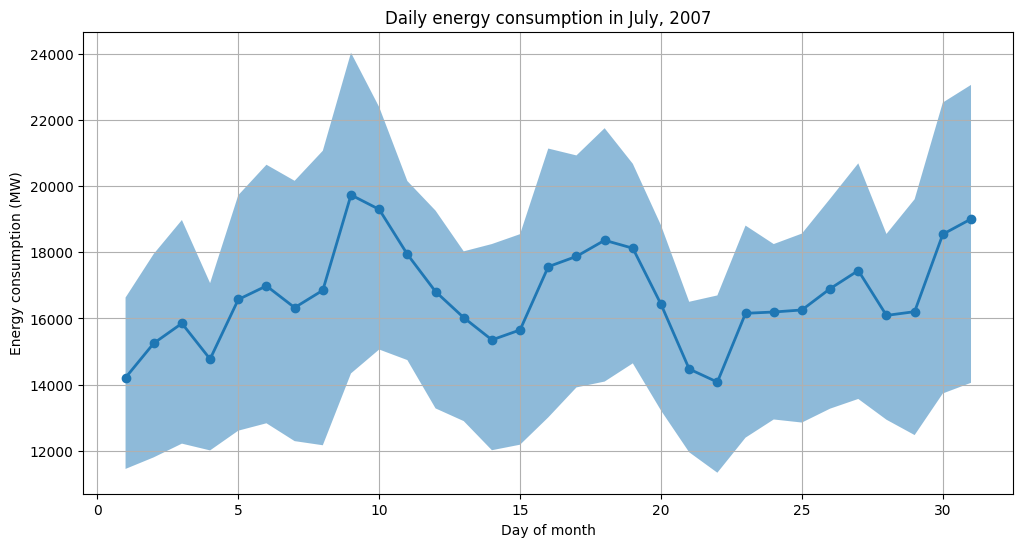

In [ ]:
plot_month(2007, 7)